In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

In [2]:
train_data_gpd = gpd.read_file(r'datasets/Train.gpkg')

In [3]:
dtm = rasterio.open(r'datasets/dtm.tif')

In [4]:
crs = train_data_gpd.crs


In [5]:
width , height = dtm.width, dtm.height
xmin, ymin, xmax, ymax = train_data_gpd.total_bounds

transform = from_bounds(xmin, ymin, xmax, ymax, width , height )
options = {'out_shape': (height, width),'transform': transform, 'dtype': rasterio.float32, 'fill': 128}

In [33]:
attribute = 'Target'
# Rasterize the GeoDataFrame based on the attribute
target_raster = rasterize([(geom, value) for geom, value in zip(train_data_gpd.geometry, train_data_gpd[attribute])], **options)

In [ ]:
#create dataframe for training, run this only once or acces directly the created df
from numpy.lib.index_tricks import ndenumerate
df_train_positions = pd.DataFrame()
rows = []
cols = []
target = []
for idx, value in np.ndenumerate(target_raster):
    if value != 128:
        rows.append(idx[0])
        cols.append(idx[1])
        target.append(value)

df_train_positions['row'] = rows
df_train_positions['col'] = cols
df_train_positions['target'] = target

rows, cols, target = None, None, None
df_train_positions.to_csv(r'datasets/row_col_target.csv')

In [34]:
with rasterio.open(r'datasets/train_raster.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.uint8,
                   crs=crs, transform=transform) as dst:
    dst.write(target_raster, 1)

In [35]:
#set raster to None to save RAM
target_raster = None


## Feature Engineering


#### DTM
##### Only Run this once -New Tif created

In [6]:
import richdem as rd

elevation = dtm.read(1)

dem = rd.rdarray(elevation, no_data=-9999)
#Fill depressions with epsilon gradient to ensure drainage
rd.FillDepressions(dem, epsilon=True, in_place=True)

#Get flow accumulation with no explicit weighting. The default will be 1.
accum_d8 = rd.FlowAccumulation(dem, method='D8')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


C:\Users\sandr\Anaconda3\anaconda\envs\DS\lib\site-packages\richdem\__init__.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


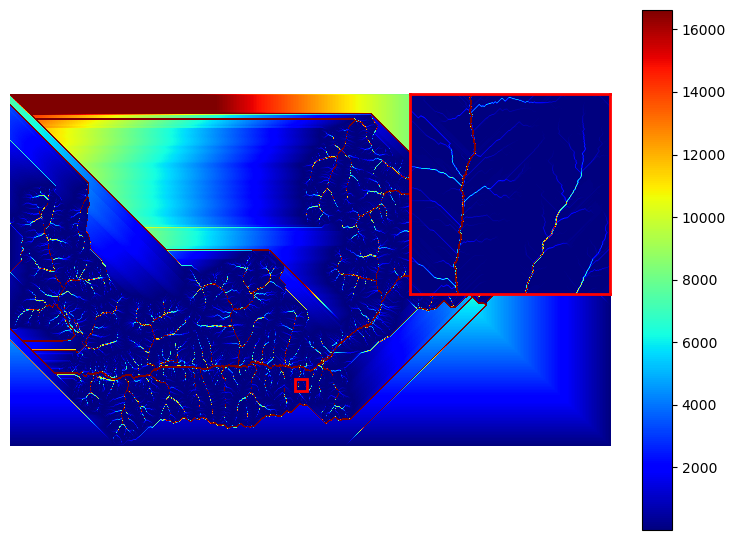

{'vmin': 1.0, 'vmax': 16619.0}

In [4]:
rd.rdShow(accum_d8, zxmin=12000, zxmax=12500, zymin=12000, zymax=12500, figsize=(8,5.5), axes=False, cmap='jet')

In [6]:
slope_rad = rd.TerrainAttribute(dem, attrib='slope_radians')

twi = np.log(25*accum_d8 / (np.tan(slope_rad)+0.01))
accum_d8 = None

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [17]:
#write slope.tif
with rasterio.open(r'datasets/slope_rad.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(slope_rad, 1)

slope_rad = None #clear RAM

#write twi.tif
with rasterio.open(r'datasets/twi.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(twi, 1)

twi = None

In [0]:
#calculate aspect and curvature

aspect = rd.TerrainAttribute(dem, attrib='aspect')
with rasterio.open(r'datasets/aspect.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(aspect, 1)

aspect = None

In [7]:
planform_curvature = rd.TerrainAttribute(dem, attrib='planform_curvature')
with rasterio.open(r'datasets/planform_curvature.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(planform_curvature, 1)

planform_curvature = None

profile_curvature = rd.TerrainAttribute(dem, attrib='profile_curvature')
with rasterio.open(r'datasets/profil_curvature.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(profile_curvature, 1)

profile_curvature = None

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [18]:


curvature = rd.TerrainAttribute(dem, attrib='curvature')
with rasterio.open(r'datasets/curvature.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(curvature, 1)

curvature = None

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


#### Precipitation

In [36]:
#90% Percentile
precipitation_90 = rasterio.open(r'datasets/90_perc_precipitation_2020.tif')
prec_90 = precipitation_90.read(1)
precipitation_90 = None
prec_90 = np.nan_to_num(prec_90, nan=-1)
with rasterio.open(r'datasets/prec_90.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(prec_90, 1)

prec_90 = None

In [40]:
avr_precipitation = rasterio.open(r'datasets/average_precipitation_2020.tif')
prec_avr = avr_precipitation.read(1)
prec_avr = np.nan_to_num(prec_avr, nan=-1)


with rasterio.open(r'datasets/prec_avr.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(prec_avr, 1)

prec_avr = None

#### Land Cover

In [4]:
land_cover_gpd = gpd.read_file(r'datasets/land_use_land_cover.gpkg')

In [5]:
land_cover_gpd['2-DESCRIZIONE'].unique()

array(['Urban areas', 'Permanent lawns', 'Forested areas',
       'Mining areas, landfills, construction sites, artificial and abandoned land',
       'Environments with evolving shrub and/or herbaceous vegetation',
       'Permanent crops', 'Open areas with sparse and absent vegetation',
       'Inland waters', 'Arable land', 'Non-agricultural green areas',
       'Production sites, large plants and communication networks',
       'Indoor wet areas', nan], dtype=object)

In [7]:
#create new classification
types = land_cover_gpd['2-DESCRIZIONE'].unique()
dict_land_types = {}

for i in range(len(types)):
    dict_land_types[types[i]] = i

options = {'out_shape': (height, width),'transform': transform, 'dtype': rasterio.float32, 'fill': -1}

# Rasterize the GeoDataFrame based on the attribute
land_cover_raster = rasterize([(geom, dict_land_types[value]) for geom, value in zip(land_cover_gpd.geometry, land_cover_gpd['2-DESCRIZIONE'])], **options)


#save it
with rasterio.open(r'datasets/land_cover_raster.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(land_cover_raster, 1)

land_cover_raster = None

#### Geological Faults

In [21]:
geo_faults_gpd = gpd.read_file(r'datasets/geological_faults.gpkg')


In [22]:
buffered_geo_100 = geo_faults_gpd.buffer(100)
buffered_geo_500 = geo_faults_gpd.buffer(500)
buffered_geo_1000 = geo_faults_gpd.buffer(1000)

In [23]:
options = {'out_shape': (height, width),'transform': transform, 'dtype': rasterio.float32, 'fill': 0}

# Rasterize the GeoDataFrame based on the attribute
geo_100_raster = rasterize([(geom, 1) for geom in buffered_geo_100], **options)

In [24]:
geo_500_raster = rasterize([(geom, 1) for geom in buffered_geo_500], **options)
geo_1000_raster = rasterize([(geom, 1) for geom in buffered_geo_1000], **options)

#sum up all rasters, the higher the number -> more/ closer geological faults nearby
geo_raster = geo_1000_raster + geo_500_raster + geo_100_raster

#save it
with rasterio.open(r'datasets/geo_faults.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(geo_raster, 1)



In [25]:
#clear memory
geo_100_raster = None
geo_500_raster = None
geo_1000_raster = None
buffered_geo_100 = None
buffered_geo_500 = None
buffered_geo_1000 = None
geo_raster = None

### Road Distances

In [26]:
road_gpd = gpd.read_file(r'datasets/road_network.gpkg')

In [27]:
#buffer 0-500m and 500-1000m , again add up the layers.
road_buffered_500 = road_gpd.buffer(500)
road_buffered_1000 = road_gpd.buffer(1000)

road_500_raster = rasterize([(geom, 1) for geom in road_buffered_500], **options)
road_1000_raster = rasterize([(geom, 1) for geom in road_buffered_1000], **options)

#sum up all rasters, the higher the number -> more/ closer geological faults nearby
road_raster = road_500_raster + road_1000_raster

road_500_raster, road_1000_raster = None, None
road_buffered_500, road_buffered_1000 = None, None

#save it
with rasterio.open(r'datasets/roads.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(road_raster, 1)

road_raster = None

### River Network Buffer

In [28]:
rivers_gpd = gpd.read_file(r'datasets/river_network.gpkg')

In [29]:
buffered_river_100 = rivers_gpd.buffer(100)
buffered_river_500 = rivers_gpd.buffer(500)
buffered_river_1000 = rivers_gpd.buffer(1000)

river_100_raster = rasterize([(geom, 1) for geom in buffered_river_100], **options)
river_500_raster = rasterize([(geom, 1) for geom in buffered_river_500], **options)
river_1000_raster = rasterize([(geom, 1) for geom in buffered_river_1000], **options)

#sum up all rasters, the higher the number -> more/ closer geological faults nearby
river_raster = river_100_raster + river_500_raster + river_1000_raster

In [30]:
river_1000_raster, river_500_raster, river_100_raster = None, None, None
buffered_river_100, buffered_river_500, buffered_river_1000 = None, None, None

#save it
with rasterio.open(r'datasets/rivers.tif', 'w', driver='GTiff', width=width, height=height, count=1, dtype=rasterio.float32,
                   crs=crs, transform=transform) as dst:
    dst.write(river_raster, 1)

river_raster = None

### Calculate Stats

In [15]:

path = r'datasets/'
elevation = rasterio.open(path + 'dtm.tif')
twi = rasterio.open(path + 'twi.tif')
slope_rad = rasterio.open(path + 'slope_rad.tif')
aspect = rasterio.open(path + 'aspect.tif')
profile_curvature = rasterio.open(path + 'profil_curvature.tif')
planform_curvature = rasterio.open(path + 'planform_curvature.tif')
curvature = rasterio.open(path + 'curvature.tif')


rain_90 = rasterio.open(path +'prec_90.tif')
rain_avr = rasterio.open(path +'prec_avr.tif')

land_cover = rasterio.open(path +'land_cover_raster.tif')
geo_faults = rasterio.open(path +'geo_faults.tif')
roads = rasterio.open(path +'roads.tif')
rivers = rasterio.open(path +'rivers.tif')



target = rasterio.open(path +'train_raster.tif')

feature_list = [elevation, twi, slope_rad, aspect, profile_curvature, planform_curvature, curvature, rain_90, rain_avr, land_cover, geo_faults, roads, rivers]
#rain_90, rain_avr, land_cover, geo_faults, roads, rivers]
add_feat = [rain_90, rain_avr, geo_faults, roads, rivers]




el = elevation.read(1)
mask = (el != 0) #filter out all cells with no data, approx lowest point in region is above 0
el = None

columns = ['elevation', 'twi', 'slope_rad', 'aspect', 'profile_curvature', 'planform_curvature','curvature', 'rain_90', 'rain_avr',
           'land_cover', 'geo_faults', 'roads', 'rivers']

index = ['mean', 'std']
stats_df = pd.DataFrame(index = index, columns = columns)

for i in range(len(feature_list)):
    col = columns[i]
    print(type(feature_list[i]), i)
    layer = feature_list[i].read(1)
    filtered_layer = layer[mask]
    mean = filtered_layer.mean()
    std = filtered_layer.std()

    stats_df[col] = [mean, std]



stats_df.to_csv(r'datasets/stats.csv')


<class 'rasterio.io.DatasetReader'> 0
<class 'rasterio.io.DatasetReader'> 1
<class 'rasterio.io.DatasetReader'> 2
<class 'rasterio.io.DatasetReader'> 3
<class 'rasterio.io.DatasetReader'> 4
<class 'rasterio.io.DatasetReader'> 5
<class 'rasterio.io.DatasetReader'> 6
<class 'rasterio.io.DatasetReader'> 7
<class 'rasterio.io.DatasetReader'> 8
<class 'rasterio.io.DatasetReader'> 9
<class 'rasterio.io.DatasetReader'> 10
<class 'rasterio.io.DatasetReader'> 11
<class 'rasterio.io.DatasetReader'> 12


land_cover


### Calculate NDVI

In [69]:
import ee


ee.Initialize()


#define RoI
bounds = dtm.bounds
coordinates = [[bounds.left, bounds.bottom],
               [bounds.right, bounds.bottom],
               [bounds.right, bounds.top],
               [bounds.left, bounds.top]]


# Convert the region of interest to an Earth Engine geometry
ee_geometry = ee.Geometry.Polygon(coords=coordinates, proj='EPSG:4326')

# Load Image Collection, only use summer -> winter snow
image_collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(ee_geometry) \
    .filterDate('2020-04-01', '2020-10-31')

# Calculate NDVI for each image in the collection
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B5', 'B4']) # NIR and Red bands
    return image.addBands(ndvi.rename('NDVI'))

# Map the NDVI calculation over the image collection
ndvi_collection = image_collection.map(calculate_ndvi)

# Resample the NDVI data to 5-meter resolution
resampled_ndvi = ndvi_collection \
    .select('NDVI') \
    .mosaic() \
    .reproject(crs='EPSG:4326', scale=5)

# Export
task = ee.batch.Export.image.toDrive(
    image=resampled_ndvi,
    description='NDVI_export',
    fileNamePrefix = 'NDVI',
    scale=5,
    fileFormat='GeoTIFF',
    folder='Landslides_data'
)

# Start the export task
task.start()

TypeError: 'method' object is not iterable